In [29]:
import blackjax
import jax

def run_unadjusted(logdensity_fn, num_steps, initial_position, key, transform):
    init_key, tune_key, run_key = jax.random.split(key, 3)

    # create an initial state for the sampler
    initial_state = blackjax.mcmc.discrete_rescaling.init(
        position=initial_position, logdensity_fn=logdensity_fn, rng_key=init_key
    )

    # print(initial_state)
    # raise Exception

    # use the quick wrapper to build a new kernel with the tuned parameters
    sampling_alg = blackjax.discrete_rescaling(
        logdensity_fn,
        L=100.0,
        step_size=.3,
        # L=L,
        # step_size=step_size,
    )

    # run the sampler
    _, samples = blackjax.util.run_inference_algorithm(
        rng_key=run_key,
        initial_state=initial_state,
        # initial_state=initial_state,
        inference_algorithm=sampling_alg,
        num_steps=num_steps,
        transform=transform,
        progress_bar=True,
    )

    return samples

<Axes: xlabel='position[0]', ylabel='position[1]'>

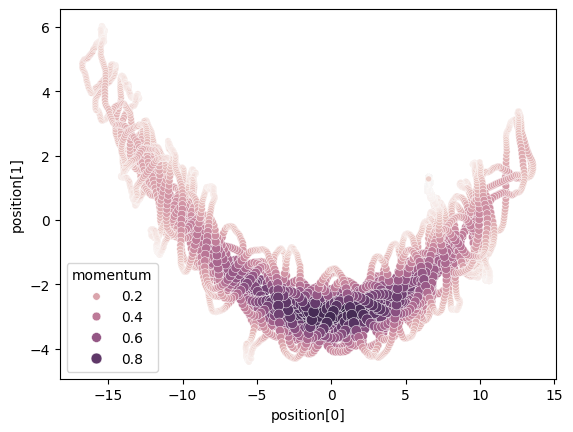

In [30]:
import jax.numpy as jnp

import sys
sys.path.append('../')
from benchmarks.inference_models import Banana, StandardNormal

# Define the log density function for the 2D standard normal distribution

model = Banana()
# logdensity_fn = lambda x: -jnp.sum(x**2)

num_steps = 10000
initial_position = model.sample_init(jax.random.PRNGKey(0))

# Set the random key
key = jax.random.PRNGKey(0)

# Run the `run_adjusted` function
samples = run_unadjusted(model.logdensity_fn, num_steps, initial_position, key, transform=lambda state, info: (state))

import pandas as pd


df = pd.DataFrame({'position[0]': samples.position[:, 0], 'position[1]': samples.position[:, 1], 'momentum': jnp.linalg.norm(samples.momentum, axis=1)**2  })

import seaborn as sns

sns.scatterplot(data=df, x='position[0]', y='position[1]', hue='momentum',size='momentum', s=3)

# jnp.linalg.norm(samples.momentum, axis=1)

# df
# print(samples.shape)

# # Print the samples
# # # print(samples)
# import matplotlib.pyplot as plt

# color_values = jnp.zeros_like(samples[:, 0])+1

# plt.plot(samples[:, 0], samples[:, 1], c=color_values, marker='o', cmap='viridis')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.axis('equal')
# plt.title('MCHMC (no bounces, yes rescaling)')
# plt.show()





<Axes: xlabel='position[0]', ylabel='position[1]'>

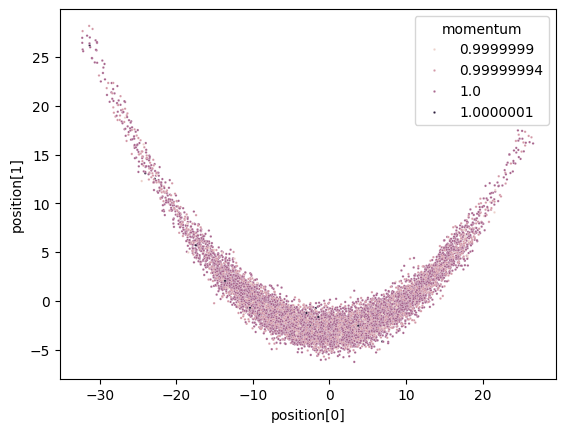

In [15]:
def run_mclmc(logdensity_fn, num_steps, initial_position, key, transform, desired_energy_variance= 5e-4):
    init_key, tune_key, run_key = jax.random.split(key, 3)

    # create an initial state for the sampler
    initial_state = blackjax.mcmc.mclmc.init(
        position=initial_position, logdensity_fn=logdensity_fn, rng_key=init_key
    )

    # build the kernel
    kernel = lambda sqrt_diag_cov : blackjax.mcmc.mclmc.build_kernel(
        logdensity_fn=logdensity_fn,
        integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
        sqrt_diag_cov=sqrt_diag_cov,
    )

    # find values for L and step_size
    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
    ) = blackjax.mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
        diagonal_preconditioning=False,
        desired_energy_var=desired_energy_variance
    )

    # use the quick wrapper to build a new kernel with the tuned parameters
    sampling_alg = blackjax.mclmc(
        logdensity_fn,
        L=blackjax_mclmc_sampler_params.L,
        step_size=blackjax_mclmc_sampler_params.step_size,
    )

    # run the sampler
    _, samples = blackjax.util.run_inference_algorithm(
        rng_key=run_key,
        initial_state=blackjax_state_after_tuning,
        inference_algorithm=sampling_alg,
        num_steps=num_steps,
        transform=transform,
        progress_bar=True,
    )

    return samples, blackjax_state_after_tuning, blackjax_mclmc_sampler_params, run_key

sample_key, rng_key = jax.random.split(jax.random.PRNGKey(0))
samples_mclmc, initial_state, params, chain_key = run_mclmc(
    logdensity_fn=model.logdensity_fn,
    num_steps=num_steps,
    initial_position=jnp.ones((2,)),
    key=sample_key,
    transform=lambda state, info: (state),
)


df_mclmc = pd.DataFrame({'position[0]': samples_mclmc.position[:, 0], 'position[1]': samples_mclmc.position[:, 1], 'momentum': jnp.linalg.norm(samples_mclmc.momentum, axis=1)  })

import seaborn as sns

sns.scatterplot(data=df_mclmc, x='position[0]', y='position[1]', hue='momentum',s=3)
# sns.scatterplot(data=df, x='position[0]', y='position[1]', hue='momentum',s=3)

